# AEWS Python Notebook 08i: AEWS miscellanea

**Author**: Eric Lehmann, CSIRO Data61  
**Date**:  July 12, 2016

**Note**: The Python code below is "rudimentary" etc. etc. Priority is here given to code interpretability rather than execution efficiency.

**Note**: this notebook should be accessible and viewable at [https://github.com/eric542/agdc_v2/tree/master/notebooks](https://github.com/eric542/agdc_v2/tree/master/notebooks).

## Summary

Building up on the concepts introduced in the previous notebooks in this series, we work out the remaining components of the AEWS implementation &mdash; see *'AEWS Python Notebook 08a'* for details of these components. The contents summary for the present notebook is given below.

**Abstract** &mdash; The computational requirements of the AEWS represent an important aspect of the implementation. They are tipically directly related to the amount of time necessary for the processing of the available data, and also to the costs of using the NCI infrastructure for commercial / industry entities. The issue of execution times required by various operations on the data was originally briefly raised in '_AEWS Python Notebook 04_' (at the start of 2nd half). In this notebook (08i), we revisit this issue and investigate in more detail some aspects of the computational requirements impacting on the AEWS implementation.  
<br>
<div class=info>
<b>NOTE:</b> based on information received following the creation of this notebook, the large computational effort identified and investigated below appears to be linked to the use of an early (pre-release) version of the AGDC v2.0 API, which was known to suffer from reading / decompression issues with NetCDF files, and which were fixed in subsequent versions &mdash; issues flagged in this notebook will thus likely disappear when the AEWS eventually starts making use of the formal AGDC v2.0 API release.
</div>

## Preliminaries

This (Jupyter) notebook was written for use on the NCI's VDI system, with the following pre-loaded module:

```
 $ module use /g/data/v10/public/modules/modulefiles --append
 $ module load agdc-py2-prod 
```

**NOTE**: the specific module loaded here (`agdc-py2-prod`) is different from the module loaded in earlier notebooks (`agdc-py2-dev`)! While the earlier module contained only Landsat 5 data, the `agdc-py2-prod` module links to a (different) AGDC database containing the following NBART/NBAR/PQA datasets:

* Landsat 8: 2013
* Landsat 7: 2013
* Landsat 5: 2006/2007

It is unclear whether the API functions in these 2 modules are identical or represent different versions.

**NOTE 2**: as of mid-June 2016, changes were made to the AGDC API v2.0, and the above Landsat datasets (and related API functions) can now be accessed through the module `agdc-py2-prod/1.0.3` (pre-major-change version). How long this module will remain accessible and/or when it will be replaced with the formal v2.0 API is still unclear at this time (June 2016).

In [1]:
%%html  # Definitions for some pretty text boxes...
<style>
    div.warn { background-color: #e8c9c9; border: 1px solid #c27070; border-left: 6px solid #c27070; padding: 0.5em }
    div.note { background-color: #cce0ff; border: 1px solid #5c85d6; border-left: 6px solid #5c85d6; padding: 0.5em }
    div.info { background-color: #ffe680; border: 1px solid #cca300; border-left: 6px solid #cca300; padding: 0.5em }
</style>

In [2]:
%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np

import ogr, gdal, osr

from pylab import rcParams
rcParams['figure.figsize'] = (10,10)   # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False   # disable scalar formatter / offset in axes labels

from pprint import pprint
from __future__ import print_function

import datacube.api   # import the AGDC v2 API, with pre-loaded 'agds-py2-dev' (or similar) NCI module
from datacube.analytics.analytics_engine import AnalyticsEngine
from datacube.execution.execution_engine import ExecutionEngine

def merge_dup_dates(xada):
    # Takes in an xarray.DataArray 'xada' as input and merges 
    # datasets (time slices) within it that have the same dates.
    # Returns the modified DataArray and vector of selected dates.
    dates = xada.coords['time'].values
    n_dates = len( dates )
    
    # Convert UTM times to local dates (d/m/y only):
    str_dates = np.zeros(n_dates).astype('str')
    for ii in range(n_dates):
        str_dates[ii] = str( dates[ii] )[:10]
    
    # Remove duplicated dates:
    rem_ind = np.zeros(n_dates).astype('bool')   # keep track of which duplicated dates to remove
    for ind in range(1,n_dates):
        dup_ind = np.where( str_dates[:ind]==str_dates[ind] )[0]   # check for duplicated date up to current index
        if len( dup_ind )!=0:   # found (at least) one duplicate
            dup_ind = dup_ind[0]   # only use the first index if multiple dates returned
            rem_ind[ind] = True    # remove current date index
            ind_n_nans = np.sum( np.isnan( xada[ind] ) ) # nr of NaN pixels in each image
            dup_n_nans = np.sum( np.isnan( xada[dup_ind] ) )
            if ind_n_nans==0:     # current data has no NaN's, use it instead of duplicate date (copy it to lowest index)
                xada[dup_ind] = xada[ind]
            elif dup_n_nans!=0:   # if duplicate date has no NaN's: do nothing (use it instead of current date)
                if dup_n_nans<ind_n_nans:   # duplicate date has less NaN's: fill it in with current data
                    tmp = np.where( np.isnan(xada[dup_ind]) )
                    xada[dup_ind].values[tmp] = xada[ind].values[tmp]
                else:   # dup_n_nans>=ind_n_nans -- duplicate date has more NaN's: use it to fill in current data
                    tmp = np.where( np.isnan(xada[ind]) )
                    xada[ind].values[tmp] = xada[dup_ind].values[tmp]
                    xada[dup_ind] = xada[ind]   # save results to lowest date index, in case >2 slices have same date
    
    return xada[~rem_ind]

## Test dataset

We'll use an example ROI defined in a previous notebook, namely the Wongalara lake in NSW, which represents a modest dataset of about 700-by-560 pixels. Also, we will use a small temporal window (18 dates only) and will here only focus on the basic (non-PQ-masked) WQ data, for simplicity.

In [3]:
lakes_file = '../NSW_lakes/NSW_WaterBody.shp'
lakes_vec = ogr.Open(lakes_file)
lakes_lyr = lakes_vec.GetLayer(0)

n_ftr = lakes_lyr.GetFeatureCount()
lname_list = list()
for kk in range( n_ftr ):
    ftr = lakes_lyr.GetFeature(kk)
    lname_list.append(ftr.GetField('hydroname'))

ftr = lname_list.index('WONGALARA')
lakes_ftr = lakes_lyr.GetFeature(ftr)
ring = lakes_ftr.GetGeometryRef().GetGeometryRef(0)
poly_array = np.array(ring.GetPoints())[:,0:2]  # lon / lat coords of polygon

In [4]:
dc = datacube.api.API()

In [5]:
dimensions = { 'lon' : { 'range': ( min(poly_array[:,0])-0.02, max(poly_array[:,0])+0.02 ) },
               'lat' : { 'range': ( max(poly_array[:,1])+0.02, min(poly_array[:,1])-0.02 ) },
               'time': { 'range': ((2013, 3, 1), (2013, 4, 15)) } }
query = { 'product': 'nbar',
          # 'platform': 'LANDSAT_7',
          'dimensions': dimensions }
desc = dc.get_descriptor(query, include_storage_units=False)

print( desc.keys() )

tmp = 'ls7_nbar_albers' in desc.keys()
tmp2 = "({} dates)".format(desc['ls7_nbar_albers']['result_shape'][0])
print( "\nDo we have LS7 data?", tmp, tmp2 if tmp else "(0 dates)")

[u'ls7_nbar_albers', u'ls8_nbar_albers']

Do we have LS7 data? True (18 dates)


## Computational requirements: Analytics & Execution Engines

First, a general observation that "re-using" an existing AE/EE setup progressively increases the time taken to set it up:

In [6]:
%%time
ae = AnalyticsEngine()
ee = ExecutionEngine()

ae_green = ae.create_array(('LANDSAT_7', 'nbar'), ['band_3'], dimensions, 'ae_green')
ae_red = ae.create_array(('LANDSAT_7', 'nbar'), ['band_2'], dimensions, 'ae_red')
aePQ = ae.create_array(('LANDSAT_7', 'pqa'), ['pixelquality'], dimensions, 'aePQ')
aeWQ = ae.apply_expression([ae_green, ae_red], '((array1 + array2) * 0.5)', 'aeWQ')
ee.execute_plan(ae.plan)

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


CPU times: user 708 ms, sys: 30 ms, total: 738 ms
Wall time: 1.44 s


In [7]:
%%time
ae_green = ae.create_array(('LANDSAT_7', 'nbar'), ['band_3'], dimensions, 'ae_green')
ae_red = ae.create_array(('LANDSAT_7', 'nbar'), ['band_2'], dimensions, 'ae_red')
aePQ = ae.create_array(('LANDSAT_7', 'pqa'), ['pixelquality'], dimensions, 'aePQ')
aeWQ = ae.apply_expression([ae_green, ae_red], '((array1 + array2) * 0.5)', 'aeWQ')
ee.execute_plan(ae.plan)

CPU times: user 971 ms, sys: 68 ms, total: 1.04 s
Wall time: 2.09 s


In [8]:
%%time
ae_green = ae.create_array(('LANDSAT_7', 'nbar'), ['band_3'], dimensions, 'ae_green')
ae_red = ae.create_array(('LANDSAT_7', 'nbar'), ['band_2'], dimensions, 'ae_red')
aePQ = ae.create_array(('LANDSAT_7', 'pqa'), ['pixelquality'], dimensions, 'aePQ')
aeWQ = ae.apply_expression([ae_green, ae_red], '((array1 + array2) * 0.5)', 'aeWQ')
ee.execute_plan(ae.plan)

CPU times: user 1.25 s, sys: 108 ms, total: 1.36 s
Wall time: 2.75 s


In [9]:
%%time
ae_green = ae.create_array(('LANDSAT_7', 'nbar'), ['band_3'], dimensions, 'ae_green')
ae_red = ae.create_array(('LANDSAT_7', 'nbar'), ['band_2'], dimensions, 'ae_red')
aePQ = ae.create_array(('LANDSAT_7', 'pqa'), ['pixelquality'], dimensions, 'aePQ')
aeWQ = ae.apply_expression([ae_green, ae_red], '((array1 + array2) * 0.5)', 'aeWQ')
ee.execute_plan(ae.plan)

CPU times: user 1.53 s, sys: 98 ms, total: 1.62 s
Wall time: 3.36 s


... and so on. Note that the `execute_plan` command does not actually carry out the calculations (more on this below), but somehow, the `ae` and `ee` objects appear to be "growing" or "updated" with each new executions, rather than being "overwritten".  
<br>
<div class=info>
<b>INFO:</b> it is probably a good idea to re-initialise the AE/EE engine objects prior to re-use.
</div>

Next, we try to identify the time-consuming operations typically used when processing the data, to see if we can potentially optimise things a bit. As we've seen above, setting up the AE/EE engines isn't a particularly time consuming procedure:

In [10]:
%%time
ae = AnalyticsEngine()
ee = ExecutionEngine()
ae_green = ae.create_array(('LANDSAT_7', 'nbar'), ['band_3'], dimensions, 'ae_green')
ae_red = ae.create_array(('LANDSAT_7', 'nbar'), ['band_2'], dimensions, 'ae_red')
aeWQ = ae.apply_expression([ae_green, ae_red], '((array1 + array2) * 0.5)', 'aeWQ')
ee.execute_plan(ae.plan)

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


CPU times: user 515 ms, sys: 13 ms, total: 528 ms
Wall time: 987 ms


Neither is the actual definition of variables related to the above operation:

In [11]:
%%time
WQ_xarray = ee.cache['aeWQ']['array_result']['aeWQ']
grn_xarray = ee.cache['ae_green']['array_result'].values()[0]
red_xarray = ee.cache['ae_red']['array_result'].values()[0]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs


Again, this here indicates that the calculations haven't actually been performed on the data yet. A bit of prodding around indicates that the main time-consuming operation are actually the process of _loading up_ the data from the AGDC database, which happens whenever the data is actually _used_ in the current environment, or which can be triggered using the Xarray `load` function:

In [12]:
%%time
tmp = red_xarray.load()

CPU times: user 2min 8s, sys: 25.9 s, total: 2min 33s
Wall time: 2min 33s


In [13]:
%%time
tmp = grn_xarray.load()

CPU times: user 2min 7s, sys: 23.7 s, total: 2min 30s
Wall time: 2min 30s


Once the Landsat data is loaded into the workspace, executing various operations on them is usually very fast. Here, we could "manually" calculate the WQ data, for instance:

In [14]:
%%time
WQ_res = (grn_xarray + red_xarray) * 0.5

CPU times: user 33 ms, sys: 22 ms, total: 55 ms
Wall time: 53.4 ms


In [15]:
%%time
WQ_res = merge_dup_dates( WQ_res )

CPU times: user 179 ms, sys: 12 ms, total: 191 ms
Wall time: 188 ms


In [16]:
%%time
tmp = np.where( ( (~np.isnan(WQ_res)).sum('x').sum('y')!=0 ).values )[0]
WQ_res = WQ_res[tmp]

CPU times: user 12 ms, sys: 5 ms, total: 17 ms
Wall time: 15.3 ms


CPU times: user 696 ms, sys: 23 ms, total: 719 ms
Wall time: 750 ms


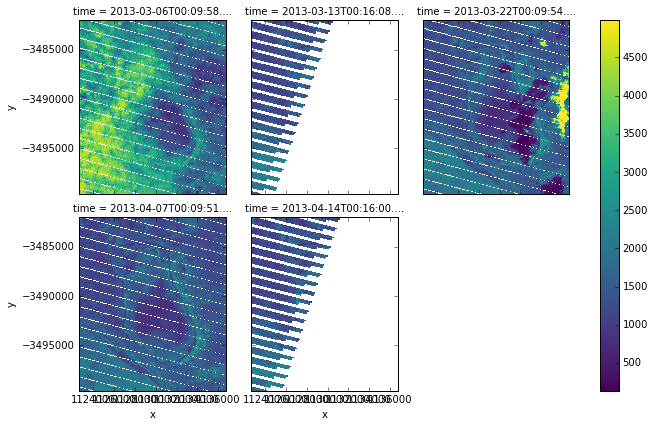

In [17]:
%%time
WQ_res.plot(col='time',col_wrap=3);

Note, however, that loading up the AE/EE variables `grn_xarray` and `red_xarray` as done so far does NOT actually execute the AE/EE calculations for `WQ_xarray`, as defined in the AE/EE statements above. For instance, we can here load up the AE/EE WQ results (same as those calculated manually above):

In [18]:
%%time
tmp = WQ_xarray.load()

CPU times: user 4min 11s, sys: 46.9 s, total: 4min 58s
Wall time: 4min 56s


Despite the availability of the red a green bands _in the workspace/memory_, this still takes a long time to execute. And given that the actual calculations (average of 2 bands) take virtually no time as shown above, this means that executing the `WQ_xarray` calculations actually _re-loads_ the bands' data! This is further confirmed by the time taken by these WQ calculations (about 5 min), which roughly corresponds to the combined times required to load the two band datasets (about 2 and a half minutes each).

But again, once the AE/EE's WQ dataset is loaded up, further processing of it is very fast, e.g. if we were to merge duplicate dates and remove empty time slices:

CPU times: user 925 ms, sys: 22 ms, total: 947 ms
Wall time: 947 ms


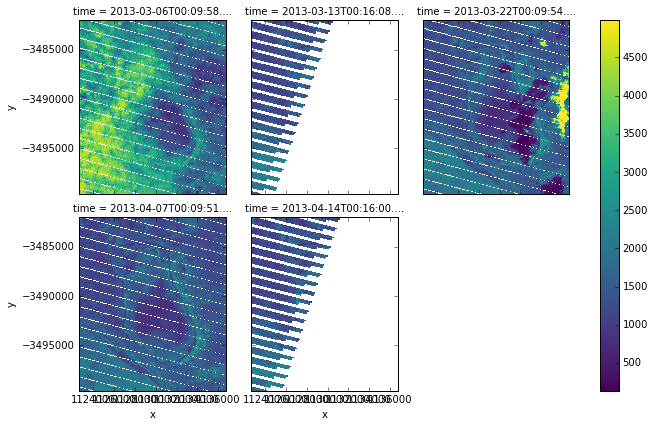

In [19]:
%%time
WQ_xarray = merge_dup_dates( WQ_xarray )
tmp = np.where( ( (~np.isnan(WQ_xarray)).sum('x').sum('y')!=0 ).values )[0]
WQ_xarray = WQ_xarray[tmp]
WQ_xarray.plot(col='time',col_wrap=3);

Also, now that all the AE/EE results have been loaded / calculated, "re-loading" them once again doesn't take time:

In [20]:
%%time
tmp = red_xarray.load()
tmp = grn_xarray.load()
tmp = WQ_xarray.load()

CPU times: user 2 ms, sys: 2 ms, total: 4 ms
Wall time: 2.73 ms


Note that the reverse is also true: if we first load up the WQ results (calculated using both the green and red bands data), then loading up the individual bands still requires the data to be practically re-loaded into the workspace:

In [21]:
%%time
ae = AnalyticsEngine()
ee = ExecutionEngine()
ae_green = ae.create_array(('LANDSAT_7', 'nbar'), ['band_3'], dimensions, 'ae_green')
ae_red = ae.create_array(('LANDSAT_7', 'nbar'), ['band_2'], dimensions, 'ae_red')
aeWQ = ae.apply_expression([ae_green, ae_red], '((array1 + array2) * 0.5)', 'aeWQ')
ee.execute_plan(ae.plan)

WQ_xarray = ee.cache['aeWQ']['array_result']['aeWQ']
grn_xarray = ee.cache['ae_green']['array_result'].values()[0]
red_xarray = ee.cache['ae_red']['array_result'].values()[0]

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


CPU times: user 489 ms, sys: 20 ms, total: 509 ms
Wall time: 979 ms


In [22]:
%%time
tmp = WQ_xarray.load()

CPU times: user 4min 12s, sys: 44.9 s, total: 4min 57s
Wall time: 4min 56s


In [23]:
%%time
tmp = red_xarray.load()

CPU times: user 2min 4s, sys: 21.7 s, total: 2min 26s
Wall time: 2min 25s


So in short, if both bands need to be loaded into the workspace, then it is less time-consuming to "manually" compute the WQ data rather than using the AE/EE results (which re-loads the bands' data again).  
<br>
<div class=info>
<b>NOTE:</b> To minimise the computational requirements, care should be taken to ensure that the AE/EE results and variables are not loaded multiple times.
</div>

As a further observation of interest, the number of AE/EE definitions (i.e. the number of bands, calculations, results, etc.) does not seem to alter the time required to load each dataset. For instance, let's define a "single-line" AE/EE result corresponding to just the green Landsat band:

In [24]:
%%time
ae = AnalyticsEngine(); ee = ExecutionEngine()
ae_green = ae.create_array(('LANDSAT_7', 'nbar'), ['band_3'], dimensions, 'ae_green')
ee.execute_plan(ae.plan)

grn_xarray = ee.cache['ae_green']['array_result'].values()[0]

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


CPU times: user 249 ms, sys: 8 ms, total: 257 ms
Wall time: 501 ms


In [25]:
%%time
tmp = grn_xarray.load()

CPU times: user 2min 6s, sys: 23.3 s, total: 2min 29s
Wall time: 2min 29s


... which still takes about the same time (about 2 and a half minute) to load.

## Computational requirements: low-level API functions

Let's now see whether the low-level API functions also require the same kind of computational requirements as the AE/EE.

In [26]:
%%time
query = { 'product': 'nbar',
          'platform': 'LANDSAT_7',
          'dimensions': dimensions,
          'variables' : ['band_3', 'band_4'] }
sat_data = dc.get_data( query )

CPU times: user 88 ms, sys: 3 ms, total: 91 ms
Wall time: 206 ms


In [27]:
%%time
tmp = sat_data['arrays']['band_3'].load()

CPU times: user 2min 6s, sys: 24.5 s, total: 2min 30s
Wall time: 2min 30s


In [28]:
%%time
tmp = sat_data['arrays']['band_4'].load()

CPU times: user 2min 8s, sys: 23.4 s, total: 2min 32s
Wall time: 2min 32s


So very similar computational requirements here, compared to the AE/EE approach. Finally, we can also check that the same result is obtained using the API's "convenience" functions:

In [29]:
%%time
tmp = dc.get_data_array( product='nbar', platform='LANDSAT_7', 
                         x=(min(poly_array[:,0])-0.02, max(poly_array[:,0])+0.02), 
                         y=(max(poly_array[:,1])+0.02, min(poly_array[:,1])-0.02),
                         dimensions={'time': {'range': ((2013, 3, 1), (2013, 4, 15)) }} )

CPU times: user 329 ms, sys: 8 ms, total: 337 ms
Wall time: 451 ms


In [30]:
%%time
res = tmp[2].load()

CPU times: user 2min 6s, sys: 23.1 s, total: 2min 29s
Wall time: 2min 29s


In addition to all of the above, an investigation of the CPU requirements (using the command `top` in a shell terminal) indicates that about 100% of one _single_ CPU is used during the time-consuming process of loading up the data, with both the AE/EE or low-level options.

## Bottom line

The main result from the above tests regarding computational requirements is that there is (at this stage) no difference in using the AE/EE approach compared to low-level API functions. With the AE/EE developments, the endeavour is that the processing will be ultimately automatically distributed across all available CPUs (8 in total on the VDI platform). The AEWS implementation can thus continue using the Analytics and Execution Engines, with the hope that further speed-up factors might be achievable in the medium term as the AGDC v2.0 API matures.

## Further discussion...

Subsequent to these tests, a discussion with the GA AGDC dev. team indicated that this issue of high CPU requirements is likely related to the use of an "older" code base where problems existed with internal chunking in dask arrays, meaning that in some cases, the entire data file would be read into memory instead of just the portion needed (and with the decompression of NetCDF data for this entire compressed file explaining the large CPU usage during the operation). 

A fix was subsequently implemented in the latest release of the AGDC v2.0 API, and this issue should basically disappear once the above code is applied to that latest module.